In [1]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import matplotlib
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.layers import Dropout
import keras
import numpy as np

Using TensorFlow backend.


In [17]:
# MAPE
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [66]:
mrt_status_1 = read_csv("mrt_status.csv")
dataset = read_csv("dataset.csv")
mrt_status = mrt_status_1
mrt_status.head()
mrt_status["day"] = mrt_status.day.apply(lambda x: pd.to_datetime(x).strftime('%Y/%m/%d'))
mrt_status = mrt_status.rename(columns={'day': 'date'})
dataset["date"] = dataset.date.apply(lambda x: pd.to_datetime(x).strftime('%Y/%m/%d'))

new_time = []
for i in range(len(mrt_status.time.values)):
    temp = mrt_status.time[i].split(":")
    if "PM" in temp[1]:
        new_time.append(int(temp[0]) + 12)
    elif "AM" in temp[1]:
        new_time.append(int(temp[0]))
        
new_time = pd.Series(new_time)

mrt_status["time"] = new_time.values

#CAT types
s = pd.Series(list(mrt_status.cat_type.values))
cat_types=pd.get_dummies(s)

#direction
dire = pd.Series(list(mrt_status.dir.values))
direction = pd.get_dummies(dire)
mrt_status = mrt_status.join(cat_types)
mrt_status = mrt_status.join(direction)

df1 = pd.merge(dataset, mrt_status, on=['time', 'date'], how='left')
df1=df1.fillna(value=0)
final_dataset = df1[["time", "holiday", "days", "weekday", "na_entry", "CAT 1", "CAT 2", "CAT 3", "CAT 4", "North Bound"]]

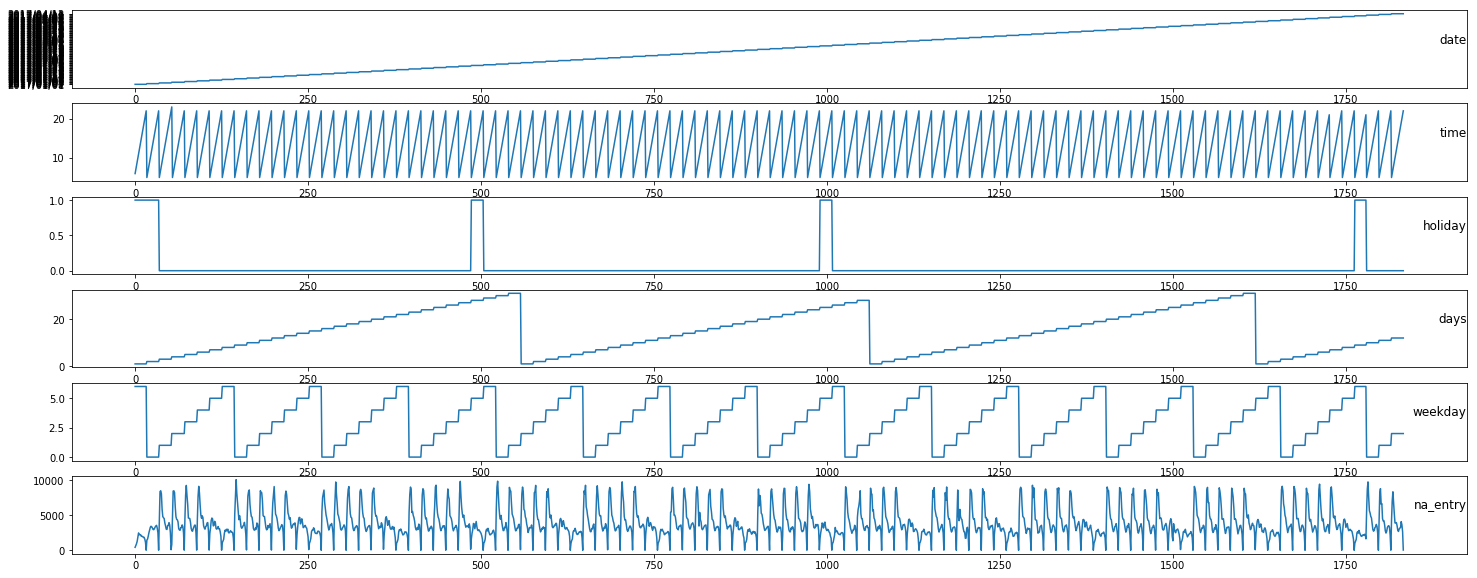

In [4]:
data = dataset[["date", "time", "holiday", "days", "weekday", "na_entry"]]
values = data.values

groups = [0,1,2,3,4,5]
i = 1

plt.figure(figsize=(25,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(data.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

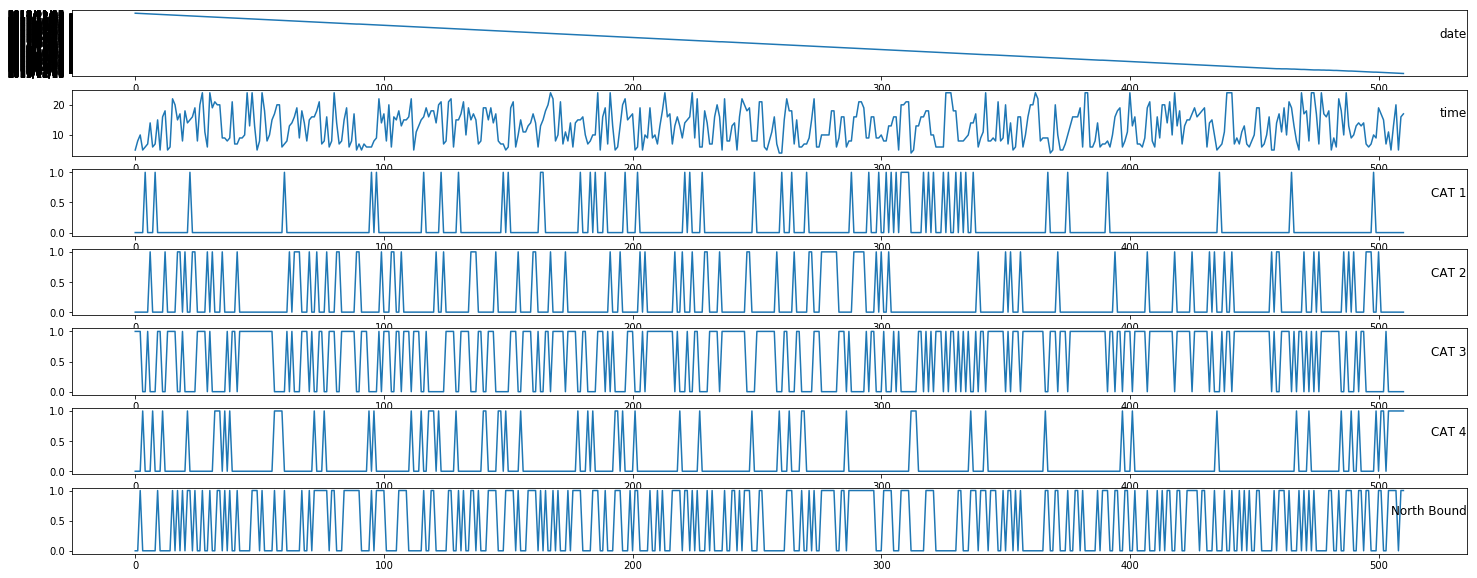

In [5]:
datadata = mrt_status[["date", "time", "CAT 1", "CAT 2", "CAT 3", "CAT 4", "North Bound"]]
values = datadata.values

groups = [0,1,2,3,4,5,6]
i = 1

plt.figure(figsize=(25,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(datadata.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

Test RMSE: 1401.418
Test MAPE 5110.380832557227


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


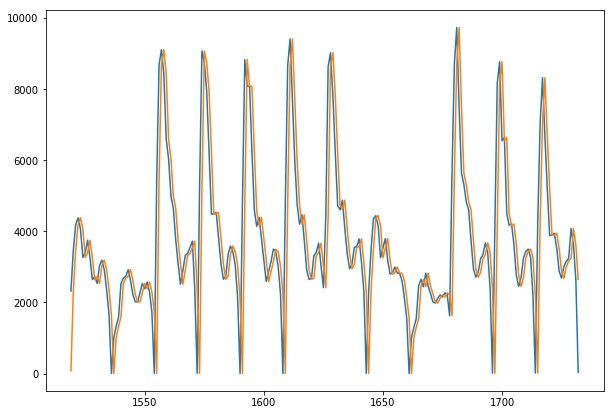

In [60]:
dataset = read_csv("dataset.csv")
dataset_ = dataset[["na_entry"]]


dataset_['na_entry'] = [1 if x == 0 else x for x in dataset_['na_entry']]

data_frame = concat([dataset_.shift(1), dataset_], axis=1)
data_frame.columns = ['t1', 't2']

# split into train and test sets
X = data_frame.values
train_size = 1520
val_size = 1620
train, validation, test = X[1:train_size], X[train_size:val_size], X[val_size:]
train_X, train_y = train[:,0], train[:,1]
val_X, val_y = validation[:,0], validation[:,1]
test_X, test_y = test[:,0], test[:,1]

# Naive Model
def model_persistence(x):
	return x
 
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % test_score)
print('Test MAPE {}'.format(mape(test_y, predictions)) )
# plot predictions and expected results
plt.figure(figsize=(10,7))
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.show()

In [213]:
# MLP Model
dataset = final_dataset[["na_entry","time", "holiday", "days", "weekday", "CAT 1", "CAT 2", "CAT 3", "CAT 4", "North Bound"]]
dataset['na_entry'] = [1 if x == 0 else x for x in dataset['na_entry']]
y_output = dataset["na_entry"].shift(1)
y_output = y_output[1:]
y_unscaled_test = y_output[val_size:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler1 = MinMaxScaler(feature_range=(0, 1))

scaler_X = scaler.fit(dataset[1:])
y_scaled = scaler1.fit_transform(y_output[:, np.newaxis])

train_size = 1520
val_size = 1620
train, validation, test = dataset_scaled[:train_size], dataset_scaled[train_size:val_size], dataset_scaled[val_size:]
train_X, train_y = train, y_scaled[:train_size]
val_X, val_y = validation, y_scaled[train_size:val_size]
test_X, test_y = test, y_scaled[val_size:]

#inverse scale
#print(scaler.inverse_transform(test_y))

def fit_model(train_X, train_y, test_X, test_y, epochs):
    model = Sequential()
    model.add(Dense(8, activation='relu', input_dim=train_X.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    adam = keras.optimizers.Adam(lr=0.008, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0005, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer= adam, metrics=['mse'])
    history = model.fit(train_X, train_y, epochs=epochs, 
              batch_size=32, validation_data=(test_X, test_y), 
              verbose=2, shuffle=True)
    
    return model, history

In [214]:
# Fit MLP Model
final_model, history = fit_model(train_X, train_y, val_X, val_y, 2500)

results = final_model.predict(val_X)
print('Validation MSE: %.3f' % mean_squared_error(val_y, results))

Train on 1520 samples, validate on 100 samples
Epoch 1/2500
 - 0s - loss: 0.0696 - mean_squared_error: 0.0696 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 2/2500
 - 0s - loss: 0.0363 - mean_squared_error: 0.0363 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 3/2500
 - 0s - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 4/2500
 - 0s - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 5/2500
 - 0s - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 6/2500
 - 0s - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.0283 - val_mean_squared_error: 0.0283
Epoch 7/2500
 - 0s - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 8/2500
 - 0s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0273 - val_mean_squared_error: 0.0273
Epoch 9/2500
 - 0s - loss: 0.0239

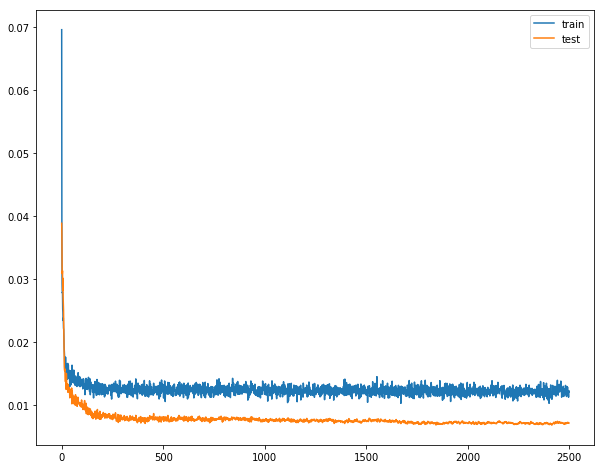

In [217]:
# Plot training and validation performance
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [218]:
h = scaler1.inverse_transform(results)

In [219]:
# Final Test MSE
stored_results = final_model.predict(test_X)
print("Test Mse: %.3f" % mean_squared_error(test_y, stored_results))

Test Mse: 0.007


In [220]:
h = scaler1.inverse_transform(stored_results)

In [221]:
len(h)

213

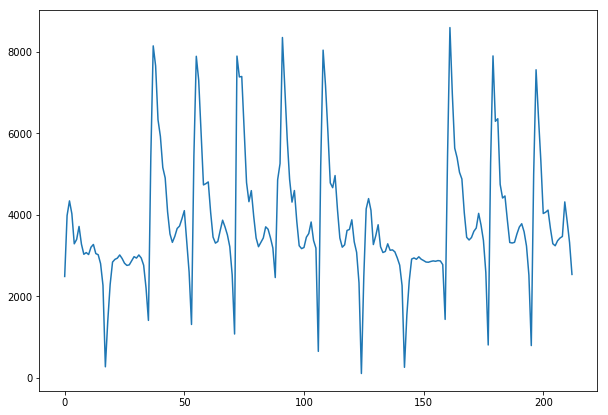

In [222]:
plt.figure(figsize=(10,7))
plt.plot(h)
plt.show()

Test Mse: 861.177
Test MAPE 10194.987939531627


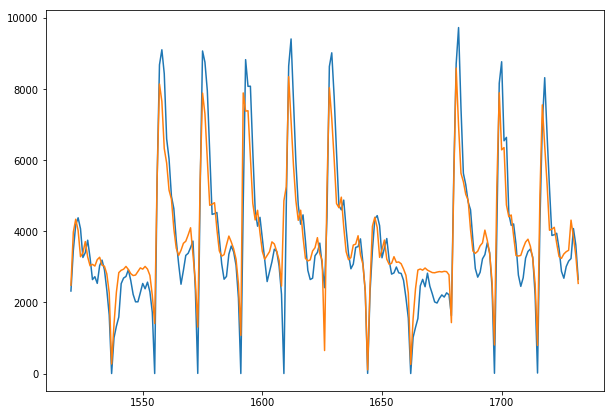

In [224]:
print("Test RMse: %.3f" % sqrt(mean_squared_error(y_unscaled_test.values, h)))
print('Test MAPE {}'.format(mape(y_unscaled_test.values, h)) )
plt.figure(figsize=(10,7))
plt.plot([None for i in train_y] + [x for x in y_unscaled_test.values])
plt.plot([None for i in train_y] + [x for x in h])
plt.show()

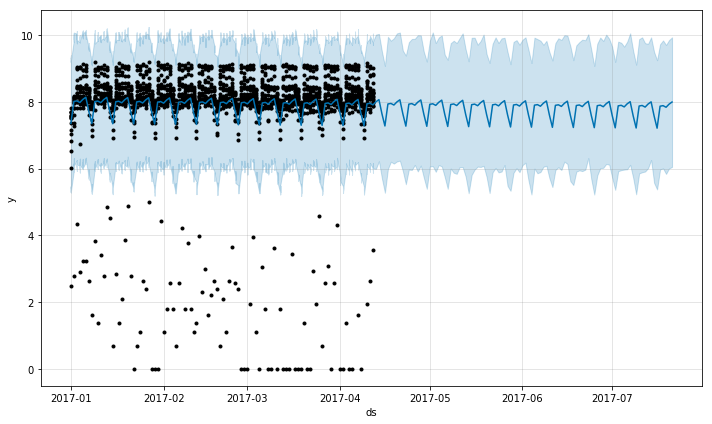

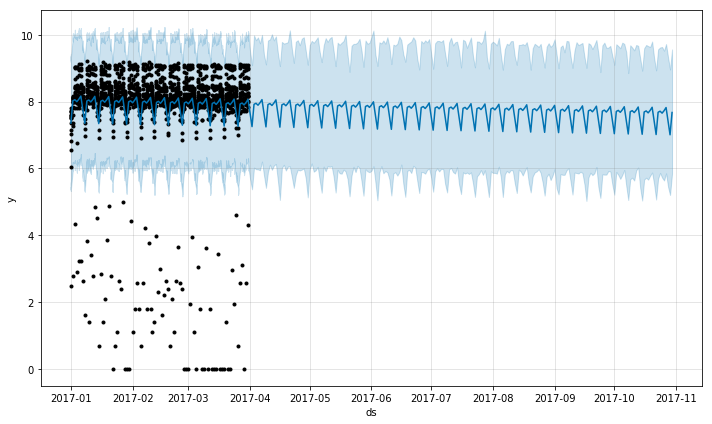

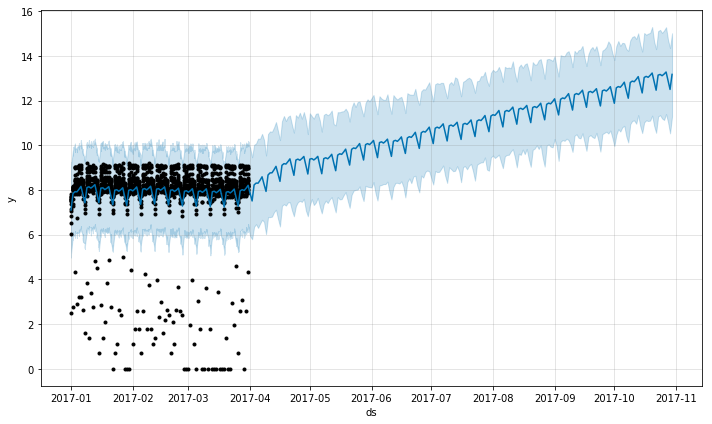

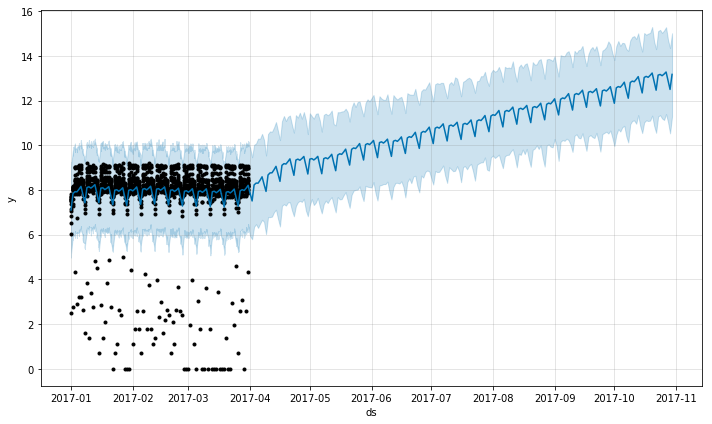

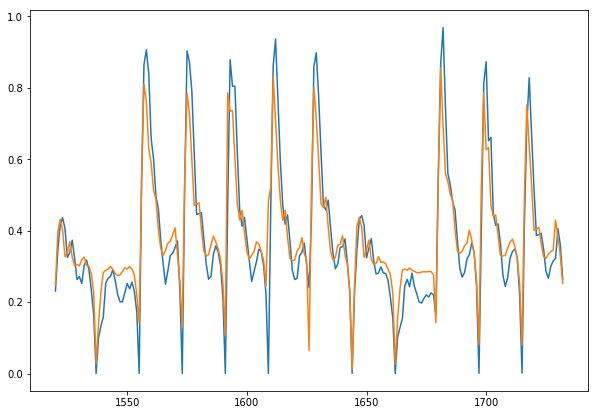

In [266]:
# Compare Predicted values to True Valuse of test set
plt.figure(figsize=(10,7))
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in stored_results])
plt.show()

In [255]:
# Python
import pandas as pd
import numpy as np
from fbprophet import Prophet

final_dataset1 = read_csv("dataset.csv")

dataset1 = final_dataset1[["date","na_entry"]]
dataset1['na_entry'] = [1 if x == 0 else x for x in dataset1['na_entry']]
dataset1['na_entry'] = np.log(dataset1['na_entry'])
dataset1.columns = ['ds', 'y']

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [257]:
m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(dataset1[:1620]);

/usr/local/lib/python3.5/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [258]:
future = m.make_future_dataframe(periods=213)
future.tail()

,ds
1828,2017-10-26
1829,2017-10-27
1830,2017-10-28
1831,2017-10-29
1832,2017-10-30


In [259]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1828,2017-10-26,13.184695,11.131199,15.136387
1829,2017-10-27,13.278527,11.395081,15.283376
1830,2017-10-28,12.876856,11.027614,14.706293
1831,2017-10-29,12.498095,10.531015,14.351222
1832,2017-10-30,13.170988,11.290275,15.012202


In [251]:
forecast

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
0,2017-01-01,7.920393,7.920393,7.920393,5.362926,9.328810,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,7.356522
1,2017-01-01,7.920393,7.920393,7.920393,5.436619,9.380096,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,7.356522
2,2017-01-01,7.920393,7.920393,7.920393,5.401591,9.268658,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,7.356522
3,2017-01-01,7.920393,7.920393,7.920393,5.372670,9.216314,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,7.356522
4,2017-01-01,7.920393,7.920393,7.920393,5.609214,9.352266,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,7.356522
5,2017-01-01,7.920393,7.920393,7.920393,5.467938,9.236144,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,7.356522
6,2017-01-01,7.920393,7.920393,7.920393,5.330406,9.314401,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,7.356522
7,2017-01-01,7.920393,7.920393,7.920393,5.405615,9.376044,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,7.356522
8,2017-01-01,7.920393,7.920393,7.920393,5.431288,9.250562,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,7.356522
9,2017-01-01,7.920393,7.920393,7.920393,5.410276,9.292330,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,-0.563871,7.356522


In [265]:
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = read_csv('shampoo-sales.csv')
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()